In [1]:
import time
from faceKeySrc import load_data,shared_dataset
import numpy as np
from sklearn.cross_validation import train_test_split
import lasagne
import theano.tensor as T
import theano
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 5005)
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
style.use('seaborn-whitegrid')

In [3]:
FTRAIN = '../data/training.csv'
FTEST = '../data/test.csv'
# load training data
data_X, data_Y = load_data(FTRAIN)

just drop all the samples with missing values, consider a better approach


In [4]:
# generate test validation split
train_set_x, valid_set_x, train_set_y, valid_set_y = train_test_split(
    data_X, data_Y, test_size=0.3, random_state=42
)

In [5]:
train_set_x = train_set_x.astype(theano.config.floatX)
train_set_y = train_set_y.astype(theano.config.floatX)
valid_set_x = valid_set_x.astype(theano.config.floatX)
valid_set_y = valid_set_y.astype(theano.config.floatX)
#########################################
# try it later to see if it improves the performance
# store traiing data into shared variable
train_set_x, train_set_y = shared_dataset(train_set_x, train_set_y)
valid_set_x, valid_set_y = shared_dataset(valid_set_x, valid_set_y)

### linear regression with multiple outputs

In [8]:
def build__model(width,
                 num_output,
                 drop_input= None,
                 drop_hidden = None,
                 input_var=None):

    # Input layer and dropout (with shortcut `dropout` for `DropoutLayer`):
    network = lasagne.layers.InputLayer(shape=(None, 9216),
                                        input_var=input_var)
    if drop_input:
        network = lasagne.layers.dropout(network, p=drop_input)
    # Hidden layers and dropout:
    nonlin = lasagne.nonlinearities.LeakyRectify(.1)
    for i in range(len(width)):
        network = lasagne.layers.DenseLayer(
            network, width[i], nonlinearity=nonlin)
        if drop_hidden:
            network = lasagne.layers.dropout(network, p=drop_hidden[0])
            drop_hidden = drop_hidden[1:]
        
    # Output layer:
    out_nonlin = lasagne.nonlinearities.identity
    network = lasagne.layers.DenseLayer(network, num_output, nonlinearity=out_nonlin)
        
    return network

In [9]:
def reinitiate_set_params(network,
                          weights = None):
        # change weights of a trained network to a random set or a user defined value
        # useful in case of big networks and cross validation
        # instead of the long time of recompiling you can just 
        # re-init the network weights
        if not weights:
            old = lasagne.layers.get_all_param_values(network)
            weights = []
            for layer in old:
                shape = layer.shape
                if len(shape)<2:
                    shape = (shape[0], 1)
                W= lasagne.init.GlorotUniform()(shape)
                if W.shape != layer.shape:
                    W = np.squeeze(W, axis= 1)
                weights.append(W)
        lasagne.layers.set_all_param_values(network, weights) 
        return network

In [17]:
def build_update_functions(train_set_x,train_set_y,
                           valid_set_x,valid_set_y,
                           network,
                           y,
                           batch_size = 32,
                           l2_reg = .01,
                           learning_rate = .005,
                           momentum = .9):
    # build update functions
    #####################################
    # extract tensor representing the network predictions
    prediction = lasagne.layers.get_output(network)
    loss_RMSE = 0
    # collect squared error
    loss_RMSE = lasagne.objectives.squared_error(prediction, y)
    # compute the root mean squared errror
    loss_RMSE = loss_RMSE.mean().sqrt()
    # add l2 regularization
    l2_penalty = lasagne.regularization.regularize_network_params(network,
                                                                  lasagne.regularization.l2)
    loss = (1-l2_reg) * loss_RMSE + l2_reg * l2_penalty
    # get network params
    params = lasagne.layers.get_all_params(network)
    
#     # create update criterion    
#     print('nestrov')
#     updates = lasagne.updates.nesterov_momentum(
#         loss, params, learning_rate=learning_rate, momentum=momentum)
    
#     print('AdaGrad')
#     updates = lasagne.updates.adagrad(loss, params)
    
    print('RMSPROP')
    updates = lasagne.updates.rmsprop(loss, params, learning_rate= .0001)
    # create validation/test loss expression
    # the loss represents the loss for all the lables
    test_prediction = lasagne.layers.get_output(network,
                                                deterministic=True)
    # collect squared error
    test_loss = lasagne.objectives.squared_error(test_prediction,
                                                 y)
    # compute the root mean squared errror
    test_loss = test_loss.mean().sqrt()
#     test_loss_withl2 = (1-l2_reg) * test_loss + l2_reg * l2_penalty
    
    # index for minibatch slicing
    index = T.lscalar()
    
    # training function 
    train_set_x_size = train_set_x.get_value().shape[0]
    val_set_x_size = valid_set_x.get_value().shape[0]
    
    train_fn = theano.function(inputs=[index],
                               outputs=[loss,loss_RMSE],
                               updates=updates,
                               givens={X:train_set_x[index * batch_size: T.minimum((index + 1) * batch_size,train_set_x_size)],
                                       y:train_set_y[index * batch_size: T.minimum((index + 1) * batch_size,train_set_x_size)]})
    # validation function 
    val_fn = theano.function(inputs=[index],
                             outputs=[test_loss,prediction],
                             givens={X:valid_set_x[index * batch_size: T.minimum((index + 1) * batch_size,val_set_x_size)],
                                     y:valid_set_y[index * batch_size: T.minimum((index + 1) * batch_size,val_set_x_size)]})
    return train_fn,val_fn

In [18]:
if type(train_set_y) == np.ndarray:
    num_output = train_set_y.shape[1]
else:
    num_output = train_set_y.get_value().shape[1]

In [19]:
X = T.matrix('X')
y = T.matrix('y')
network = build__model([1024,1024,512,128],
                       num_output=num_output,
                       drop_input=.1,
                       drop_hidden=[.1,.2,.3,.3],
                       input_var = X)

In [20]:
train_fn,val_fn = build_update_functions(train_set_x,train_set_y,
                                         valid_set_x,valid_set_y,
                                         network,
                                         y)

RMSPROP


In [21]:
# parasms 
n_iter = 10000
improvement_threshold = 0.999
patience = 10000
max_fail = 10
#######################
batch_size = 642
n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size+1
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size+1
patience_increase=2
validation_frequency = min(n_train_batches, patience // 10)
best_val_loss_ = np.inf
train_loss_history_temp = []
########################
n_fail_ = 0
best_val_loss_ = np.inf
best_epoch_ = 0 
epoch = 0
done_looping = False
train_loss_history_ = []
val_loss_history_ =[]

In [22]:
print train_set_x.get_value().shape[0]
print valid_set_x.get_value().shape[0]

1498
642


In [23]:
start_time = time.time()
while (epoch < n_iter) and (not done_looping):
    epoch +=1
    
    # go over minibatches
    for minibatch_index in range(n_train_batches):
        
        # update network for one minibatch
        minibatch_average_cost,minibatch_average_RMSE = train_fn(minibatch_index)
        
        # store training loss of minibatches till the next validation step
        train_loss_history_temp.append(minibatch_average_RMSE)
        
        # number of minibatches checked
        num_minibatch_checked = (epoch -1) * n_train_batches + minibatch_index
        
        # if validation interval reached
        if (num_minibatch_checked+1 ) % validation_frequency ==0:
            
            # compute validation loss
            validation_losses = [val_fn(i)[0] for i in range(n_valid_batches)]
            
            # store mean validation loss for validation set
            current_val_loss = np.mean(validation_losses)
            
            # store training and validation history
            train_loss_history_.append(np.mean(train_loss_history_temp))
            val_loss_history_.append(current_val_loss)
            train_loss_history_temp = []

            # is it the best validation loss sofar?
            if current_val_loss < best_val_loss_ :
                
                # increase patience if improvement is significant
                if (current_val_loss < best_val_loss_*improvement_threshold):
                    patience = max(patience, num_minibatch_checked* patience_increase )
                
                # save the-sofar-best validation RMSE and epoch and model-params
                best_val_loss_ = current_val_loss
                best_epoch_ = epoch
                best_network_params = lasagne.layers.get_all_param_values(network)
                
        # check if patience exceeded and set the training loop to stop
        if (patience <= num_minibatch_checked):
            print 'patience reached'
            # reset the network weights to the best params saved
            print 'reseting the network params to that of the best seen'
            reinitiate_set_params(network=network,
                                  weights = best_network_params)
            # done optimising, break the optimisation loop
            done_looping = True
            break
   
    # print out results of optimising priodically
    if (epoch % 200) == 0:
        print (('epoch %i, minibatch %i/%i, validation loss of %f, patience %i, in %f secs')%
               (epoch, minibatch_index+1, n_train_batches, current_val_loss, patience, time.time()-start_time ))
        start_time = time.time()
                
        

epoch 200, minibatch 3/3, validation loss of 0.098085, patience 10000, in 17.792389 secs
epoch 400, minibatch 3/3, validation loss of 0.075455, patience 10000, in 17.343431 secs
epoch 600, minibatch 3/3, validation loss of 0.072522, patience 10000, in 17.336241 secs
epoch 800, minibatch 3/3, validation loss of 0.065442, patience 10000, in 17.241262 secs
epoch 1000, minibatch 3/3, validation loss of 0.064868, patience 10000, in 17.221843 secs
epoch 1200, minibatch 3/3, validation loss of 0.064542, patience 10000, in 17.184172 secs
epoch 1400, minibatch 3/3, validation loss of 0.064631, patience 10000, in 17.154996 secs
epoch 1600, minibatch 3/3, validation loss of 0.064810, patience 10000, in 17.148193 secs
epoch 1800, minibatch 3/3, validation loss of 0.064933, patience 10000, in 17.149413 secs
epoch 2000, minibatch 3/3, validation loss of 0.064996, patience 10000, in 17.153616 secs
epoch 2200, minibatch 3/3, validation loss of 0.065082, patience 10000, in 17.154779 secs
epoch 2400, mi

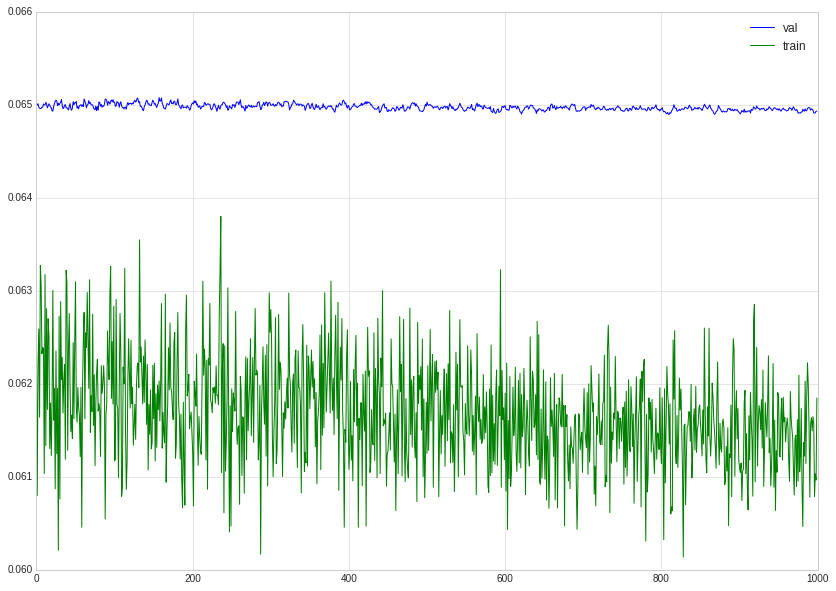

In [24]:
plt.figure(figsize=(14,10))
plt.plot(val_loss_history_[-1000:]);
plt.plot(train_loss_history_[-1000:]);
plt.legend(['val','train'])

In [171]:
# start_time = time.time()
# while (epoch < n_iter) and (not done_looping):            
#             epoch += 1
#             if (epoch % 200) == 0:
#                 print 'val loss l2',val_loss,'val loss',val_RMSE,'epoch',epoch,'n_fail',n_fail_,'in', time.time()-start_time,'SECs'
#                 start_time = time.time()

#             # one ful epoch on training data
#             train_loss = train_fn(train_set_x, train_set_y)
            
#             # And a full pass over the validation data:
#             val_loss,val_RMSE,_ = val_fn(valid_set_x, valid_set_y)
                                   
#             # save trainin history
#             train_loss_history_.append(train_loss)
#             val_loss_history_.append(val_loss)

#             # check for early stopping

#             if np.mean(val_loss) < np.mean(best_val_loss_) * improvement_threshold:
#                 best_val_loss_ = val_loss
#                 best_epoch_ = epoch 
#                 best_network_params = lasagne.layers.get_all_param_values(network)
#                 # you can later init a network with this weights by set_all_params_values
#                 # it contains both W and b of all layers
#                 n_fail_ = 0
#             elif (epoch % patience)==0:
#                 n_fail_ += 1        
            
#             if n_fail_ == max_fail : 
#                 done_looping = True
#                 reinitiate_set_params(network=network,
#                                       weights = best_network_params)
#                 break

In [179]:
best_val_loss_

0.063524798

### make a submission 

In [52]:
val_fn(train_set_x,train_set_y)

TypeError: ('Bad input argument to theano function with name "<ipython-input-46-5b651cd22a05>:58"  at index 0(0-based)', 'Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?')

### CNN 